# SHAP

Shapley Additive exPlanations (SHAP) is a method to explain predictions connecting optimal credit allocation with local explanations using the classic Shapley values from cooperative game theory and their related extensions.

The idea of this interpretation is mainly addressing the protein embeddings data in the following context:

protein embeddings used for training are built in the load_df function using a "linear" approach, if can be seen as a LF or matrix multiplication in a sense:
Let $X$ be the `samples x genes` gene expression matrix (genes and proteins here are used interchangeably), and $E$ be the `proteins x embedding_dimension` protein embeddings matrix, then the protein embeddings for samples $A$ is computed as:
$$A = \frac{X  E}{\sum_j X_j}$$

Where $A$ is the `samples x proteins` protein embeddings matrix, input of the ML models (its the matrix multiplication + row normalization)

To make the training process more interpretable we aim to use SHAP values to link the importance of each protein embedding dimension back to the genes/proteins space, so a plan of 2 steps: find the most important embedding dimensions using SHAP, then link them back to genes/proteins by computing "loadings" (similar concept to pca loading or the ones from MOFA) that are the contributing the most to these embedding dimensions (they behave like highly weighted features in a linear model).

This notebook is solely dedicated to the first step: finding the most important embedding dimensions using SHAP.
The next step will be peformed in a loadings_analysis.ipynb notebook and some ideas to look into are:
* ranked list of contributing genes/proteins per important embedding dimension
This would allow finding individual genes/proteins that are important for sepsis prediction, particulalry at top/bottom of the ranked list
* pathway enrichment analysis
each embedding will behave as a "gene program" and what's left is to find which known pathways are enriched in these programs (using functional class scoring methods such as GSEA)
* some viz like umap of protein embeddings colored by weights 
(note: this umap actually portray a very distinct pattern worth investigating, see [`latent_space.ipynb`](../viz/latent_space.ipynb) last plot)
  

### imports

In [3]:
MAIN_DUMP='../../dump/'
import os,sys
from joblib import Parallel, delayed,dump,load

sys.path.append(os.path.abspath('../../src/ml'))
from load_matrix import load_df
from model_trainer import MLModel
from utils import load_models

import pandas as pd

from evaluator import Evaluator
from collector import ResultsCollector
from visualizer import DashboardVisualizer

import shap

### vars prep

In [4]:
current_version='v2.10'
standard_models=load_models(MAIN_DUMP,version=current_version,normalization='standard')
robust_models=load_models(MAIN_DUMP,version=current_version,normalization='robust')
none_models =load_models(MAIN_DUMP,version=current_version,normalization='none')
log1p_models=load_models(MAIN_DUMP,version=current_version,normalization='log1p')
minmax_models=load_models(MAIN_DUMP,version=current_version,normalization='minmax')

In [5]:
current_dict=none_models

In [6]:
models_dict={}
for model_name in current_dict.keys():
    model=current_dict[model_name]
    print(f"-- evaluating {model_name}")
    models_dict[model_name]=model
    

-- evaluating pytorch_mlp_Complex_protein_embeddings_gridsearch_model.joblib
-- evaluating pytorch_mlp_Complex_sample_embeddings_gridsearch_model.joblib
-- evaluating pytorch_mlp_concatenated_protein_embeddings_gridsearch_model.joblib
-- evaluating pytorch_mlp_concatenated_sample_embeddings_gridsearch_model.joblib
-- evaluating pytorch_mlp_gene_expression_gridsearch_model.joblib
-- evaluating pytorch_mlp_RGCN_protein_embeddings_gridsearch_model.joblib
-- evaluating pytorch_mlp_RGCN_sample_embeddings_gridsearch_model.joblib
-- evaluating random_forest_Complex_protein_embeddings_gridsearch_model.joblib
-- evaluating random_forest_Complex_sample_embeddings_gridsearch_model.joblib
-- evaluating random_forest_concatenated_protein_embeddings_gridsearch_model.joblib
-- evaluating random_forest_concatenated_sample_embeddings_gridsearch_model.joblib
-- evaluating random_forest_gene_expression_gridsearch_model.joblib
-- evaluating random_forest_RGCN_protein_embeddings_gridsearch_model.joblib
-- 

In [7]:
dfs={
    'gene_expression':load_df('gene_expression'),
    'Complex_protein_embeddings':load_df('Complex_protein_embeddings'),
    'RGCN_protein_embeddings':load_df('RGCN_protein_embeddings'),
    'Complex_sample_embeddings':load_df('Complex_sample_embeddings'),
    'RGCN_sample_embeddings':load_df('RGCN_sample_embeddings'),
    'concatenated_protein_embeddings':load_df('concatenated_protein_embeddings'),
    'concatenated_sample_embeddings':load_df('concatenated_sample_embeddings')
}

 Complex embeddings detected in /mnt/c/Users/rayan/Documents/saclay/courses/deep-learning-and-artifical-intelligence/project/2526-m2geniomhe-GNN-sepsis/models/executions/GSE54514_enriched_ontology_degfilterv2.9/outputmodel_Complex_entity_embeddings.npy, splitting real+imag.
 Complex embeddings detected in /mnt/c/Users/rayan/Documents/saclay/courses/deep-learning-and-artifical-intelligence/project/2526-m2geniomhe-GNN-sepsis/models/executions/GSE54514_enriched_ontology_degfilterv2.9/outputmodel_Complex_entity_embeddings.npy, splitting real+imag.
 Complex embeddings detected in /mnt/c/Users/rayan/Documents/saclay/courses/deep-learning-and-artifical-intelligence/project/2526-m2geniomhe-GNN-sepsis/models/executions/GSE54514_enriched_ontology_degfilterv2.9/outputmodel_ComplEx_entity_embeddings.npy, splitting real+imag.
 Complex embeddings detected in /mnt/c/Users/rayan/Documents/saclay/courses/deep-learning-and-artifical-intelligence/project/2526-m2geniomhe-GNN-sepsis/models/executions/GSE54

## XGBoost
trial on protein_embeddings for xgboost model

--- SHAP values for xgboost_Complex_protein_embeddings_gridsearch_model.joblib ---


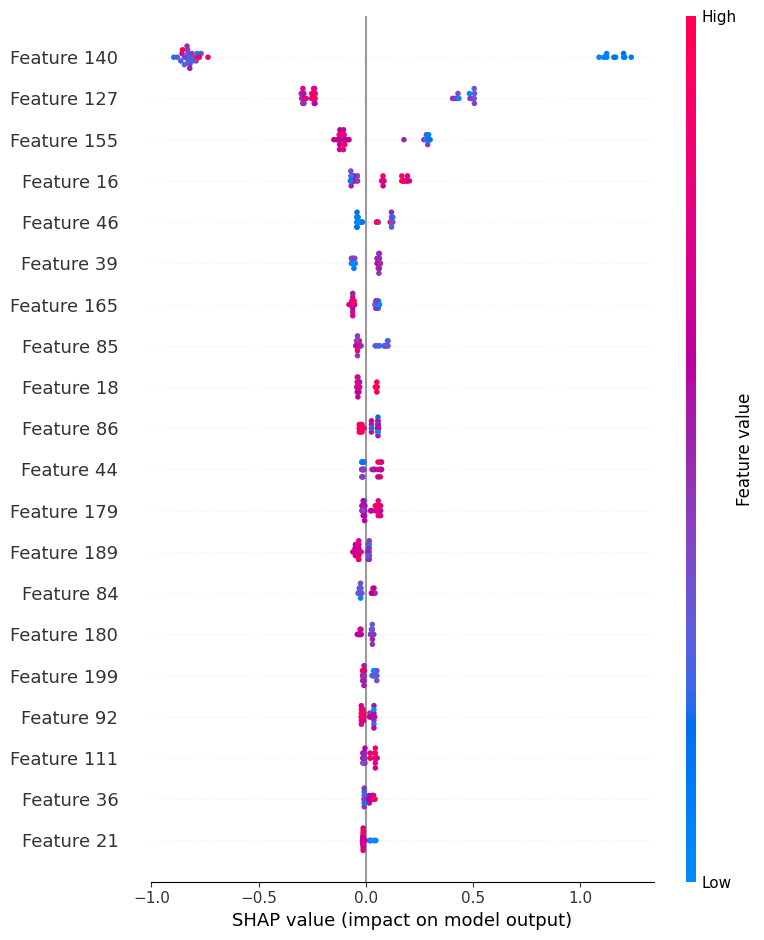

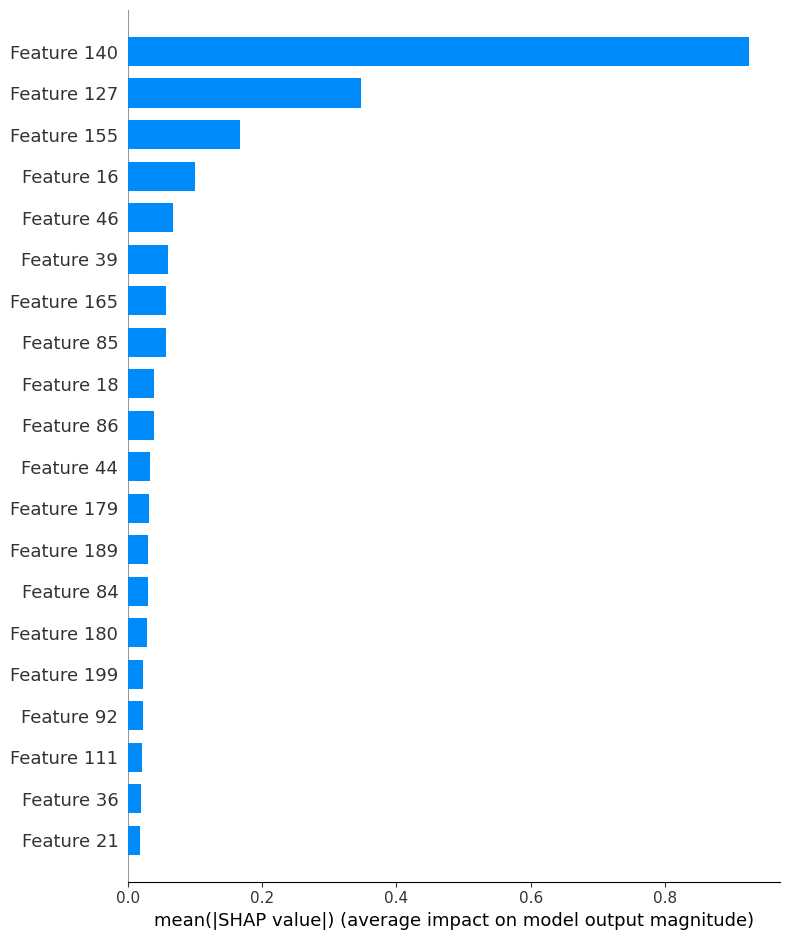

--- SHAP values for xgboost_concatenated_protein_embeddings_gridsearch_model.joblib ---


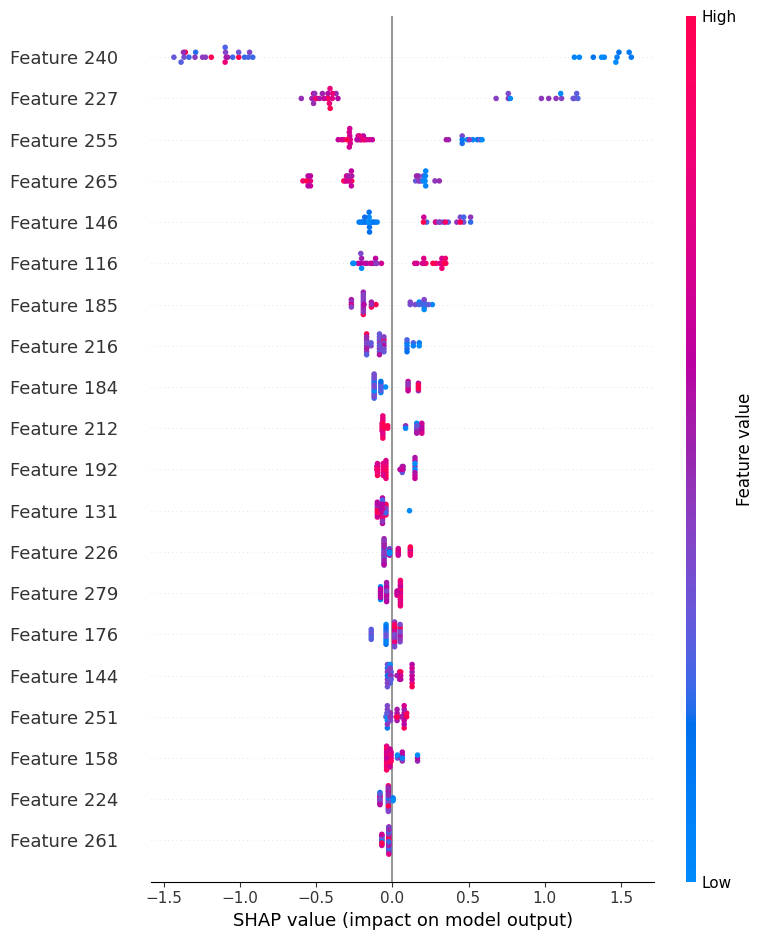

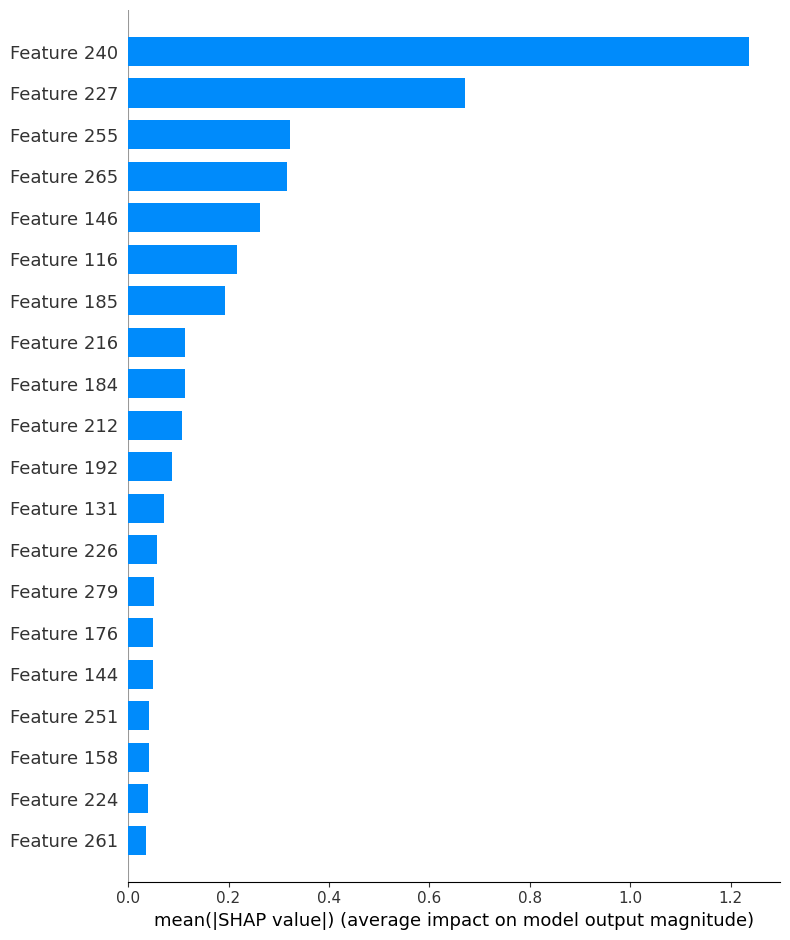

--- SHAP values for xgboost_RGCN_protein_embeddings_gridsearch_model.joblib ---


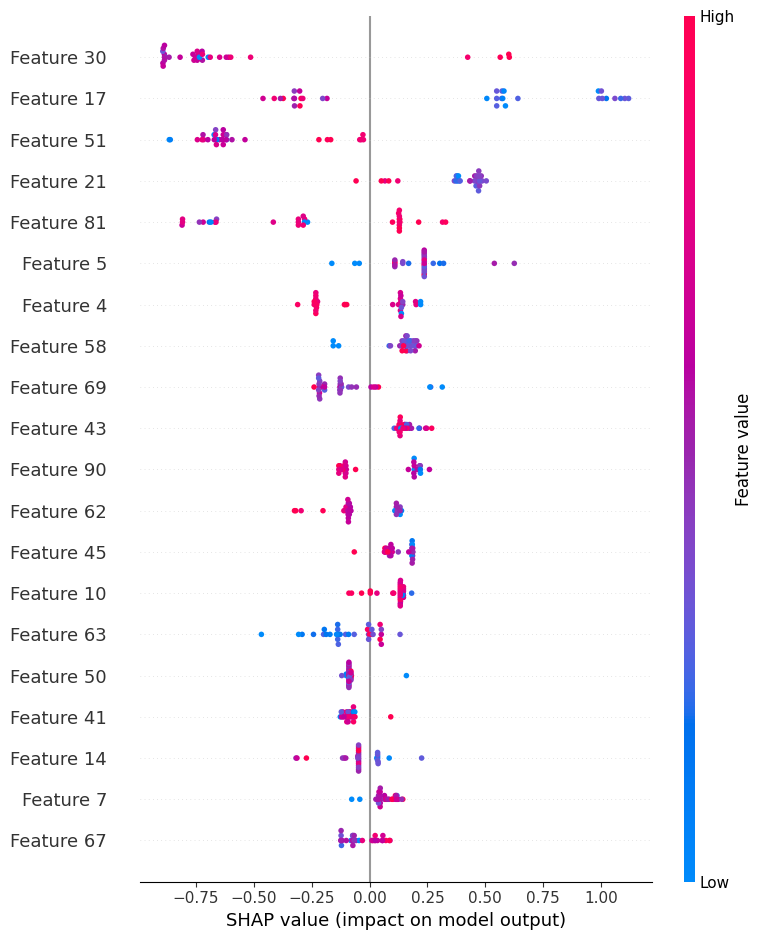

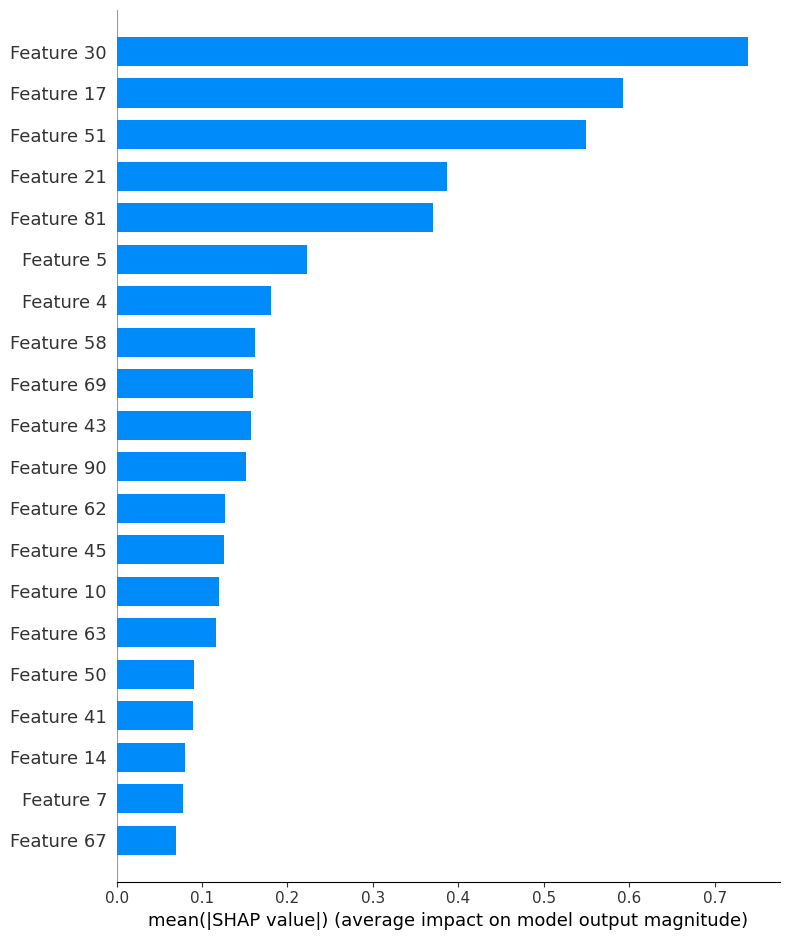

In [9]:
import shap

shap_dict={}

for model_name in models_dict.keys():
    if 'boost' in model_name and 'protein_embeddings' in model_name:
        print(f"--- SHAP values for {model_name} ---")
        model=models_dict[model_name]
        # -- based on which dfs.keys() is found in model_name, we select the appropriate dataframe
        df=None
        for key in dfs.keys():
            if key in model_name:
                df=dfs[key]
                break

        X_train,X_test,y_train,y_test=model.get_data_split(df)
        explainer = shap.TreeExplainer(model.best_model)
        
        shap_values_test= explainer.shap_values(X_test)

        shap_dict[model_name]=shap_values_test

        shap.summary_plot(shap_values_test, X_test)
        shap.summary_plot(shap_values_test, X_test, plot_type="bar")



In [11]:
# -- get top shap 
top_shap_features={}
for model_name in shap_dict.keys():
    shap_values=shap_dict[model_name]
    # -- get mean absolute shap value for each feature
    mean_abs_shap_values=shap_values.mean(axis=0)
    # -- get top 20 features
    top_20_indices=mean_abs_shap_values.argsort()[-20:][::-1]
    top_20_features=[f"feature_{i}" for i in top_20_indices]
    top_shap_features[model_name]=top_20_features

In [13]:
# -- what;s feature 127 in the data
for model_name in top_shap_features.keys():
    print(f"--- Top SHAP features for {model_name} ---")
    print(top_shap_features[model_name])

--- Top SHAP features for xgboost_Complex_protein_embeddings_gridsearch_model.joblib ---
['feature_16', 'feature_46', 'feature_127', 'feature_86', 'feature_179', 'feature_155', 'feature_36', 'feature_44', 'feature_85', 'feature_121', 'feature_111', 'feature_145', 'feature_199', 'feature_39', 'feature_81', 'feature_151', 'feature_1', 'feature_92', 'feature_180', 'feature_158']
--- Top SHAP features for xgboost_concatenated_protein_embeddings_gridsearch_model.joblib ---
['feature_227', 'feature_146', 'feature_116', 'feature_212', 'feature_144', 'feature_152', 'feature_77', 'feature_181', 'feature_251', 'feature_107', 'feature_158', 'feature_231', 'feature_192', 'feature_109', 'feature_130', 'feature_121', 'feature_255', 'feature_242', 'feature_150', 'feature_79']
--- Top SHAP features for xgboost_RGCN_protein_embeddings_gridsearch_model.joblib ---
['feature_21', 'feature_17', 'feature_5', 'feature_43', 'feature_58', 'feature_45', 'feature_10', 'feature_7', 'feature_74', 'feature_40', 'fe